# In Tutorial 5&6
we try to build up our own dataset, and create our own network, and implete the entire training process.

Now, we are trying to run the above progress on GPU

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# a trick
REBUILD_DATA = False

In [3]:
# data pre-processing is super important

class DogsVSCats():
    IMG_SIZE = 50 # want to normailize all the images, make it 50 * 50 pixels

    # note that data augment is really common in CV

    CATS = '../../../dataset/kagglecatsanddogs_5340/PetImages/Cat'
    DOGS = '../../../dataset/kagglecatsanddogs_5340/PetImages/Dog'

    LABELS = {CATS: 0, DOGS: 1}

    training_data = []

    # keep balanced data is super important 
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS: # iterating the keys
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # color doesnt matter in clasifying the cat and dog
                    # note that we want to make our data and nn as small as possible
                    img = cv2.resize(img, [self.IMG_SIZE, self.IMG_SIZE]) # reshape in 50 * 50
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    # count our data
                    if label == self.CATS:
                        self.catcount += 1
                    if label == self.DOGS:
                        self.dogcount += 1

                except Exception as e:
                    # print(str(e))
                    pass


        np.random.shuffle(self.training_data) # shuffle is inplace
        np.save('training_data.npy', self.training_data)

        print('cats:', self.catcount)
        print('dogs:', self.dogcount)

In [4]:
# COOL!!
# one-hot code
np.eye(5)[2] # 5 classes, one-hot code for class 3(2+1)

array([0., 0., 1., 0., 0.])

In [5]:
if REBUILD_DATA: # never run this again!
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()

In [6]:
training_data = np.load('training_data.npy', allow_pickle=True) # ???

In [7]:
print(len(training_data))

24946


In [8]:
print(training_data[0])
# label is [0, 1], hence its a dog

[array([[125,  54, 169, ..., 133, 141, 148],
        [124,  58, 170, ..., 134, 141, 141],
        [128,  61, 172, ..., 133, 154, 143],
        ...,
        [159,  76,  40, ..., 119, 120, 135],
        [156,  78,  30, ..., 112, 119, 121],
        [144,  80,  26, ..., 106, 113, 125]], dtype=uint8) array([0., 1.])]


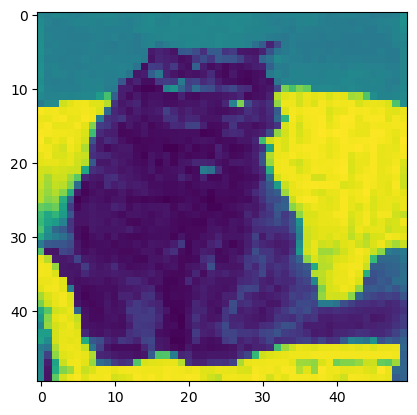

In [9]:
# show the picture
from matplotlib import pyplot as plt

index_demo = 4

plt.imshow(training_data[index_demo][0])
plt.show()

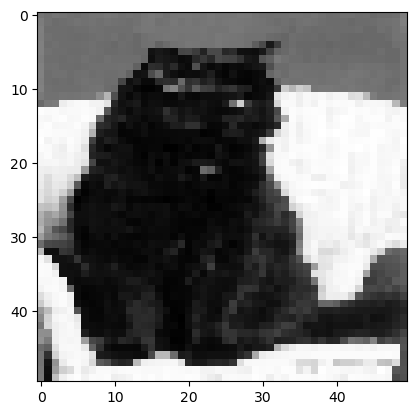

In [10]:
plt.imshow(training_data[index_demo][0], cmap='gray') # matplotlib is not only for image
plt.show()

In [11]:
training_data[index_demo][1]

array([1., 0.])

# Train Session
In tutorial 5, we built out dataset for training. Then, in this tutorial 6, we are trying to build our network and fit on our data.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # define conv layer
        self.conv1 = nn.Conv2d(
            in_channels=1, # our image is 1 * 50 *50
            out_channels=32,
            kernel_size=5
        )
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        # define pool layer
        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )
        self.pool2 = nn.MaxPool2d((2, 2))
        self.pool3 = nn.MaxPool2d(2)

        # define fc layer, but need to know the shape
        value = 512

        self.fc1 = nn.Linear(
            in_features=value, 
            out_features=512
        )
        
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):

        # a standard CNN structure is input -> (conv layer -> active func -> pool layer) -> next structure 
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # for first time, make sure the dim of x
        x = x.flatten(start_dim=1)
        # print(x.shape)

        # after feature extraction, use fc to do classification
        # a standard FC structure is input -> (fc layer -> active func) -> next structure
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1) # make sure each row is a distribution (dim=1)

        return x

really make sure that, active func is not required but probably you should have one

for instance, if we forget the `F.softmax()` for final x, and we run and fit the model. Probably, the model also works on THIS problem. Maybe it helps on much more complicated task.

In [13]:
net = Net()

In [14]:
sample_view_shape = torch.randn(1, 1, 50, 50)
net.forward(sample_view_shape)
# here 512 is our dim after flatten

tensor([[0.5048, 0.4952]], grad_fn=<SoftmaxBackward0>)

nn is actually a lot of trials and errors, nobody knows what they are doing.

anybody who claims to be like expert at neural network is a dirty lier!

In [15]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [16]:
# make sure what is inside our data
for i in training_data:
    print(i.shape)
    break

(2,)


In [17]:
# reshape our data in nn
X = torch.Tensor(np.array([i[0] for i in training_data])).view(-1, 50, 50)
X = X / 255 # each pixel is in range [0, 255], this line is to scale the data

y = torch.Tensor([i[1] for i in training_data])

C:\Users\pc\AppData\Local\Temp\ipykernel_2380\1661397904.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  y = torch.Tensor([i[1] for i in training_data])


In [18]:
valid_perc = 0.1
valid_size = int(len(X) * valid_perc)
valid_size

2494

In [19]:
train_X = X[:-valid_size]
train_y = y[:-valid_size]

test_X = X[-valid_size:]
test_y = y[-valid_size:]

In [20]:
len(train_X), len(test_X)

(22452, 2494)

In [21]:
batch_size = 128
epochs = 1

# not using the API from torch.utils.data.DataLoader

for epoch in range(epochs):
    for i in tqdm(range(0, len(train_X), batch_size)):
        # print(i, i + batch_size)
        batch_X = train_X[i:i + batch_size].view(-1, 1, 50, 50) # claim the channel number
        batch_y = train_y[i:i + batch_size] # no need to reshape?

        # make sure the optimizer or net
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

print('final loss: ', loss.item())

100%|██████████| 176/176 [00:33<00:00,  5.18it/s]

final loss:  0.2024189829826355


In [22]:
# model evaluation
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))): # batch = 1
        y_ = torch.argmax(test_y[i])
        prob_hat = net(test_X[i].view([-1, 1, 50, 50]))[0] # reshape it into dim1
        y_hat = torch.argmax(prob_hat)

        if y_hat == y_:
            correct += 1
        
        total += 1
    
    print('Accuracy: ', round(correct / total, 3))

        

100%|██████████| 2494/2494 [00:02<00:00, 1062.72it/s]

Accuracy:  0.647


# Tutorial 7

In [23]:
torch.cuda.is_available()

True

In [24]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

if you have multiple GPUs, Pytorch is easy to assign specific layer to specific GPU

for example, the encoder-decoder network

In [25]:
torch.cuda.device_count()

1

In [26]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [27]:
# try to make functions for training and testing process
def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001) # optimizer is supervising the net.params on GPU
    loss_function = nn.MSELoss()

    batch_size = 128
    epochs = 3

    # not using the API from torch.utils.data.DataLoader

    for epoch in range(epochs):
        for i in tqdm(range(0, len(train_X), batch_size)):
            # print(i, i + batch_size)
            batch_X = train_X[i:i + batch_size].view(-1, 1, 50, 50).to(device) # claim the channel number
            batch_y = train_y[i:i + batch_size].to(device) # no need to reshape?

            # make sure the optimizer or net
            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1} loss: ', loss.item())


def test(net):
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(test_X))): # batch = 1
            y_ = torch.argmax(test_y[i]).to(device)
            prob_hat = net(test_X[i].view([-1, 1, 50, 50]).to(device))[0] # reshape it into dim1
            y_hat = torch.argmax(prob_hat)

            if y_hat == y_:
                correct += 1
            
            total += 1
        
        print('Accuracy: ', round(correct / total, 3))

In [28]:
train(net)

100%|██████████| 176/176 [00:05<00:00, 31.61it/s] 


Epoch 1 loss:  0.19994524121284485


100%|██████████| 176/176 [00:01<00:00, 113.88it/s]


Epoch 2 loss:  0.1589963436126709


100%|██████████| 176/176 [00:01<00:00, 114.24it/s]

Epoch 3 loss:  0.11201731115579605


In [29]:
test(net)

100%|██████████| 2494/2494 [00:02<00:00, 1039.95it/s]

Accuracy:  0.716
